![title](https://pythonawesome.com/content/images/2018/05/scikit-learn.png)

# Learning Curves

In [1]:
# Import standard libraries
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve

__Question__: How to use Learning Curves to Diagnose Machine Learning Model Performance?

This lecture aim is to define and study an important tool for diagnostic of a machine learning algorithm: __learning curves__.

> A learning curve is a plot of model learning performance over experience or time.

In other words, one can say that _Learning Curves_ provide a mathematical representation of the learning process that takes place as task repetition occurs.

The model can be evaluated on the training dataset and on a hold out validation dataset after each update during training and plots of the measured performance can created to show learning curves.

Reviewing learning curves of models during training can be used to diagnose problems with learning, such as an underfit or overfit model, as well as whether the training and validation datasets are suitably representative.

An interesting, but quite technical, reading may be found [here](https://www.sciencedirect.com/science/article/abs/pii/S016981411100062X).

First of all we need to choose a way to parametrise the learning performance. 
This is done through a metric (the ones we have studied previously). One can be, for instance, the learning accuracy, or precision, etc.

## Working on real-world example

In [2]:
def download_data_zip(url, excel = False):
    """
    Download a ZIP file and extract its contents in memory
    :return: a pandas dataframe
    """
    from requests import get
    from io import BytesIO
    from zipfile import ZipFile

    request = get(url)
    zip_file = ZipFile(BytesIO(request.content))
    files = zip_file.namelist()
    if excel:
        namefile = [file for file in files if 'xlsx' in file][0]
        with zip_file.open(namefile, 'r') as excelfile:
            df = pd.read_excel(excelfile)
    else:
        with zip_file.open(files[0], 'r') as csvfile:
            df = pd.read_csv(csvfile)
    
    return df

In [3]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00294/CCPP.zip'

columns = ['AmbientalTemperature', 'ExhaustVacuum', 'AmbientalPressure', 'RelativeHumidity', 'ElectricalEnergyOutput']

df_data = download_data_zip(url, excel = True)
df_data.columns = columns

In [4]:
df_data.describe()

,AmbientalTemperature,ExhaustVacuum,AmbientalPressure,RelativeHumidity,ElectricalEnergyOutput
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


The `ElectricalEnergyOutput` is the target variable. All the others are features.

In [5]:
features = columns[:-1]
target = columns[-1]

Let’s first decide what training set sizes we want to use for generating the learning curves. The minimum value is $1$. The maximum is given by the number of instances in the training set. As one can see, our training set has $9568$ instances, so the maximum value is $9568$. However, we want to put aside a validation set. We will do that using an $80:20$ ratio, ending up with a training set of $7654$ instances ($80\%$), and a validation set of $1914$ instances ($20\%$). Given that our training set will have $7654$ instances, the maximum value we can use to generate our learning curves is $7654$.

In [7]:
train_sizes = [1, 100, 500, 2000, 5000, 7654] # For our case, we use these six sizes.

### The `learning_curve` function from `scikit-learn`

We are going to use the library [function](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html) `learning_curve` to generate a learning curve for a simple regression model.

There’s no need on our part to put aside a validation set because the function will take care of that.

In [8]:
train_sizes, train_scores, validation_scores = learning_curve(
estimator = LinearRegression(),
X = df_data[features],
y = df_data[target], train_sizes = train_sizes, cv = 5,
scoring = 'neg_mean_squared_error')

In the cell above, we made use of `learning_curve` to generate the data needed to plot a learning curve. 
The function returns a tuple containing three elements: 
1. the training set sizes;
2. the error scores on the validation sets;
3. the error scores on the training sets. 

The function takes the following parameters:

* __estimator__: indicates the learning algorithm we use to estimate the true model;
* __X__: the data containing the features;
* __y__: the target data;
* __train_sizes__: specifies the training set sizes to be used;
* __cv__: determines the cross-validation splitting strategy;
* __scoring__: indicates the error metric to use.

In our case, the standard metric for a linear regression problem as measure error (or cost function) is the mean squared error (MSE) metric. However, we want something like a _score_ meaning something to be maximised, rather than minimised. For this reason we used the negative version of MSE, obtained by just flipping a sign.

In [9]:
print('Training scores:\n\n', train_scores)
print('\n', '=' * 70) # separator to make the output easy to read
print('\nValidation scores:\n\n', validation_scores)

Training scores:

 [[ -0.          -0.          -0.          -0.          -0.        ]
 [-19.71230701 -18.31492642 -18.31492642 -18.31492642 -18.31492642]
 [-18.14420459 -19.63885072 -19.63885072 -19.63885072 -19.63885072]
 [-21.53603444 -20.18568787 -19.98317419 -19.98317419 -19.98317419]
 [-20.47708899 -19.93364211 -20.56091569 -20.4150839  -20.4150839 ]
 [-20.98565335 -20.63006094 -21.04384703 -20.63526811 -20.52955609]]

 ----------------------------------------------------------------------

Validation scores:

 [[-619.30514723 -379.81090366 -374.4107861  -370.03037109 -373.30597982]
 [ -21.80224219  -23.01103419  -20.81350389  -22.88459236  -23.44955492]
 [ -19.96005238  -21.2771561   -19.75136596  -21.4325615   -21.89067652]
 [ -19.92863783  -21.35440062  -19.62974239  -21.38631648  -21.811031  ]
 [ -19.88806264  -21.3183303   -19.68228562  -21.35019525  -21.75949097]
 [ -19.9046791   -21.33448781  -19.67831137  -21.31935146  -21.73778949]]


Since we specified six training set sizes, one might have expected six values for each kind of score.

Instead, we got six rows for each, and every row has five error scores. 

__Question__: Why we obtained such an apparently weird result?

This happens because `learning_curve()` runs a $k$-fold cross-validation under the hood, where the value of $k$ is given by what we specify for the `cv` parameter. In our case, 
`cv = 5`, so there will be five splits. 

For each split, an estimator is trained for every training set size specified. 
Each column in the two arrays above designates a split, and each row corresponds to a test size. 

__Question__: How do we assign a single score value to a $k$-fold validation procedure?

Nothing easier! Average over the $k$ values.

In [10]:
train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)
print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))

Mean training scores

 1       -0.000000
100     18.594403
500     19.339921
2000    20.334249
5000    20.360363
7654    20.764877
dtype: float64

 --------------------

Mean validation scores

 1       423.372638
100      22.392186
500      20.862362
2000     20.822026
5000     20.799673
7654     20.794924
dtype: float64


### Learning curves and $k$-fold validation

Before proceeding to plot our learning curves, one might have noticed, we got a lot of identical values in the numerical results above, related to training set values.
The aim of this brief section is to explore the reason behind this behaviour.

First of all, for train size$ = 1$ this is something expected.
What about the other rows? With the exception of the last row, we have a lot of identical values.

This is due to the fact we have not randomised the training data for each split. 

Let’s walk through a single example with the aid of the diagram below. When the training size is $500$ the first $500$ instances in the training set are selected.

For the first split, these $500$ instances will be taken from the second chunk. 
From the second split onward, these $500$ instances will be taken from the first chunk. 
Because we do not randomize the training set, the $500$ instances used for training are the same for the second split onward. This explains the identical values from the second split onward for the $500$ training instances case. An identical reasoning applies to the $100$ instances case, and a similar reasoning applies to the other cases. 

![title](https://www.dataquest.io/wp-content/uploads/2019/01/splits.png)

To avoid this behavior, we need to set to `True` a parameter called `shuffle` in the `learning_curve` function.
This will randomise the indices for the training data for each split. 
We did not randomise above for two reasons:

1. The data comes pre-shuffled five times (as mentioned in the [documentation](https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant)) so there were no need to randomise anymore.

2. Randomising, how could I have explained this? 😊

### Plotting learning curves

We are now ready to plot!

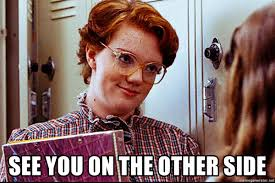

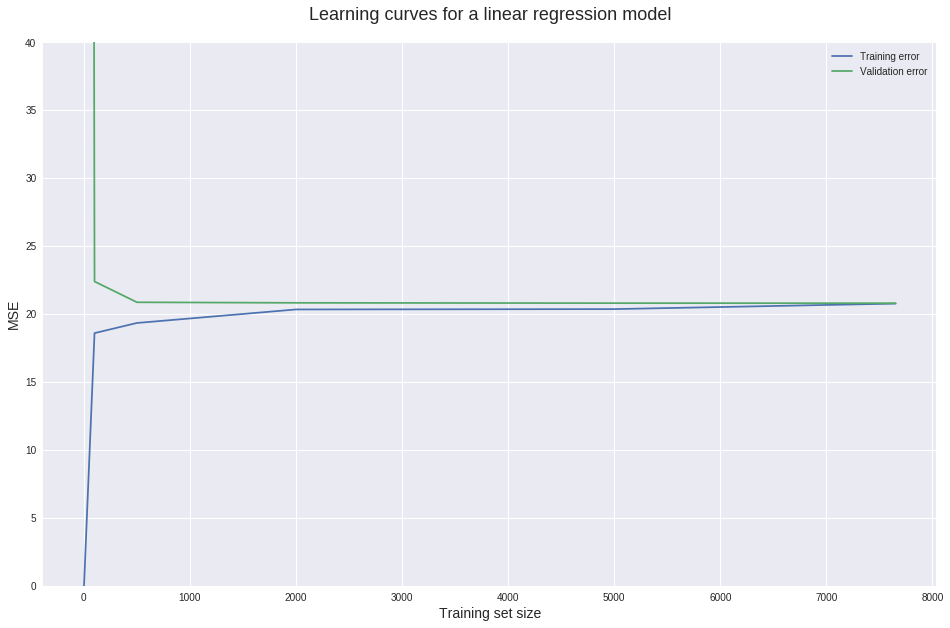

In [27]:
plt.style.use('seaborn')
plt.figure(figsize = (16,10))
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03)
plt.ylim(0,40)
plt.legend()

#### Plot analysis

There is a lot of information we can extract from the plot above.

When the training set size is $1$, we can see that the error metric for the training set is $0$. This is normal, since the model has no problem fitting perfectly a single data point. 
So when tested upon the same data point, the prediction is perfect. But when tested on the _validation set_ (which has $1914$ instances), the MSE rockets up to roughly $423.4$. This relatively high value is the reason we restrict the y-axis range between $0$ and $40$. This enables us to read most MSE values with precision. Such a high value is expected, since it’s extremely unlikely that a model trained on a single data point can generalize accurately to $1914$ new instances it has not seen in training. 

This is the extreme example of overfitting. Perfect results on training set and high values of error on validation set.

When the training set size increases to $100$, the training MSE increases sharply, while the validation MSE decreases likewise.
The linear regression model doesn’t predict all $100$ training points perfectly, so the training MSE is greater than $0$. 
However, the model performs much better now on the validation set because it is estimated with more data. 

From $500$ training data points onward, the validation MSE stays roughly the same. 
This tells us something extremely important: 

> Adding more training data points will not lead to significantly better models. So instead of wasting time (and possibly money) with collecting more data, we need to try something else, like switching to an algorithm that can build more complex models. 


We are in a situation like in the left plot below.
On the other hand if the learning curves plot would have been the right hand case, adding more data to training example would have improved the situation.

![title](https://www.dataquest.io/wp-content/uploads/2019/01/add_data.png)

To avoid a misconception here, it is important to stress the fact that what really does not help is adding more instances (rows) to the training data. 
Adding more features, on the other hand, is a different thing and is very likely to help because it increases the complexity of our current model. 

Let’s now move to diagnosing bias and variance. 

### Bias

The main indicator of a _bias_ problem is a _high validation error_. 
In our current case, the validation MSE stagnates at a value of approximately $20$. 
But how good is that? 
We would benefit from some _domain knowledge_ (perhaps physics or engineering in this case) to answer this, so the best thing is to ask to some collaborator, here we cannot, so we ask google.

Technically, that value of $20$ has MW$^2$ (megawatts squared), recall that the error metric is the mean _squared_ error, thus units have been squared. Thus, to compare with the values in the target column we have to take the square root,

$$ \sqrt{20\, \mathrm{MW}^2} \simeq 4.5\, \mathrm{MW}$$

Each target value represents net _hourly_ electrical energy output. So for each hour our model is off by $4.5$ MW on average. 
According to [this Quora answer](https://www.quora.com/How-can-I-get-an-intuitive-understanding-of-what-a-Kw-Mw-Gw-of-electricity-equates-to-in-real-life-terms), $4.5$ MW is equivalent to the heat power produced by $4500$ handheld hair dryers. And this would add up if we tried to predict the total energy output for one day or a longer period. We can conclude that the an mean squared error of $20$ MW is quite large. Hence, we can conclude our model has a bias problem.

__Question__: But is it a low bias problem or a high bias problem?

To find the answer, we need to look at the _training error_. 

If the training error is low, it means that the training data is fitted very well by the estimated model. 
If the model fits the training data very well, it means it has low bias with respect to that set of data. 

If the training error is high, it means that the training data is not fitted well enough by the estimated model. If the model fails to fit the training data well, it means it has high bias with respect to that set of data. 

![title](https://www.dataquest.io/wp-content/uploads/2019/01/low_high_bias.png)

In our particular case, the training MSE plateaus at a value of roughly $20$ MW$^2$. 
As we have already established, this is a high error score. Since the validation MSE is high, and the training MSE is high as well, our model has a high bias problem.

### Variance

Now let’s move with diagnosing eventual variance problems.

Estimating variance can be done in at least two ways:

* By examining the gap between the validation learning curve and training learning curve.
* By examining the training error: its value and its evolution as the training set sizes increase.

![title](https://www.dataquest.io/wp-content/uploads/2019/01/lc_regression.png)

A narrow gap indicates low variance. 

Generally, the more narrow the gap, the lower the variance. 
The opposite is also true: the wider the gap, the greater the variance. 

Let’s now explore why this is the case. As we have discussed earlier, if the variance is high, then the model fits training data too well. When training data is fitted too well, the model will have trouble generalizing on data that has not seen in training. 
When such a model is tested on its training set, and then on a validation set, the training error will be low and the validation error will generally be high. As we change training set sizes, this pattern continues, and the differences between training and validation errors will determine that gap between the two learning curves.

The relationship between the training and validation error, and the gap $\Delta$ can be summarized this way: 

$$ \Delta = \varepsilon_{\mathrm{validation}} - \varepsilon_{\mathrm{training}} \, .  $$

So the bigger the difference between the two errors, the bigger the gap. The bigger the gap, the bigger the variance. In our case, the gap is very narrow, so we can safely conclude that the variance is low. High training scores are also a quick way to detect low variance. If the variance of a learning algorithm is low, then the algorithm will come up with simplistic and similar models as we change the training sets. Because the models are overly simplified, they cannot even fit the training data well (they underfit the data). So we should expect high training errors and, conversely, high training error may be used as an indicator of low variance.

![title](https://www.dataquest.io/wp-content/uploads/2019/01/low_high_var.png)

In our case, the training MSE plateaus at around $20$, and we have already concluded that is an high value. So besides the narrow gap, we now have another confirmation that we have a low variance problem. So far, we can conclude that:

* Our learning algorithm suffers from high bias and low variance, _i.e._ __underfitting__ the training data.

* Adding more data examples to the training data is hugely unlikely to lead to better models under the current learning algorithm.

__Question__: how do we fix this?

For sure, we can state that trying to increase the number of training instances would be a mistake.

Generally, these are the most common fixes working when dealing with a high bias and low variance problem:

1. Changing to a more complex learning algorithm. This should decrease the bias and increase the variance. 

2. Training the current learning algorithm on more features (to avoid collecting new data, you can generate easily polynomial features). This should lower the bias by increasing the model’s complexity.

3. Decreasing the regularization of the current learning algorithm, if that is the case. In a nutshell, regularization prevents the algorithm from overfitting the training data. If we decrease regularization, the model will fit training data better, and, as a consequence, the variance will increase and the bias will decrease.

#### the low bias and high variance case

Let’s see how an unregularized Random Forest regressor fares here. 

We will generate the learning curves using the same workflow as above. This time we will bundle everything into a function so we can use it for later. For comparison, we will also display the learning curves for the previous linear regression model above.

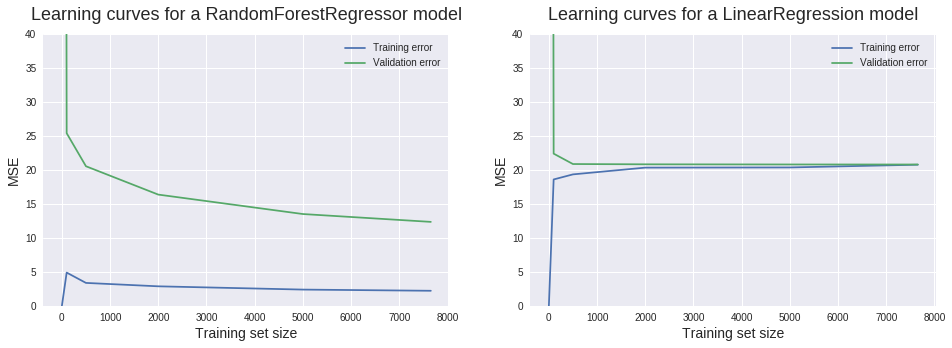

In [21]:
### Bundling our previous work into a function ###
def learning_curves(estimator, data, features, target, train_sizes, cv):
    train_sizes, train_scores, validation_scores = learning_curve(
    estimator, data[features], data[target], train_sizes =
    train_sizes,
    cv = cv, scoring = 'neg_mean_squared_error')
    train_scores_mean = -train_scores.mean(axis = 1)
    validation_scores_mean = -validation_scores.mean(axis = 1)

    plt.plot(train_sizes, train_scores_mean, label = 'Training error')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')

    plt.ylabel('MSE', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
    plt.title(title, fontsize = 18, y = 1.03)
    plt.legend()
    plt.ylim(0,40)

### Plotting the two learning curves ###

plt.figure(figsize = (16,5))

for model, i in [(RandomForestRegressor(n_estimators=10), 1), (LinearRegression(),2)]:
    plt.subplot(1,2,i)
    learning_curves(model, df_data, features, target, train_sizes, 5)

Now let’s try to apply what we have just learned. 

It would be a good idea to pause reading at this point and try to interpret the new learning curves yourself. Looking at the validation curve, we can see that we have managed to decrease bias. There still is some significant bias, but not that much as before. Looking at the training curve, we can deduce that this time there is a low bias problem.

The new gap between the two learning curves suggests a substantial increase in variance. The low training MSEs corroborate this diagnosis of high variance. The large gap and the low training error also indicates an overfitting problem. __Overfitting__ happens when the model performs well on the training set, but far poorer on the test (or validation) set. One more important observation we can make here is that adding new training instances is very likely to lead to better models. The validation curve does not plateau at the maximum training set size used. It still has potential to decrease and converge toward the training curve, similar to the convergence we see in the linear regression case. 

So far, we can conclude that:

* Our learning algorithm (random forests) suffers from high variance and quite a low bias, overfitting the training data.

* Adding more training instances is very likely to lead to better models under the current learning algorithm.

__Question__: What can we do to improve our model?

1. Well, first of all adding more training data.

2. As opposite to the previous case, increasing the regularization for our current learning algorithm. This should decrease the variance and increase the bias.

3. Reducing the numbers of features in the training data we currently use. The algorithm will still fit the training data very well, but due to the decreased number of features, it will build less complex models. This should increase the bias and decrease the variance.

In our case, as in the majority of practical situations, we do not have any other readily available data.

Let’s rather try to regularize our random forests algorithm. One way to do that is to adjust the maximum number of _leaf nodes_ in each decision tree. This can be done by using the `max_leaf_nodes` parameter of `RandomForestRegressor`. 

It is not necessarily for you to understand this regularization technique. For our purpose here, what you need to focus on is the effect of this regularization on the learning curves.

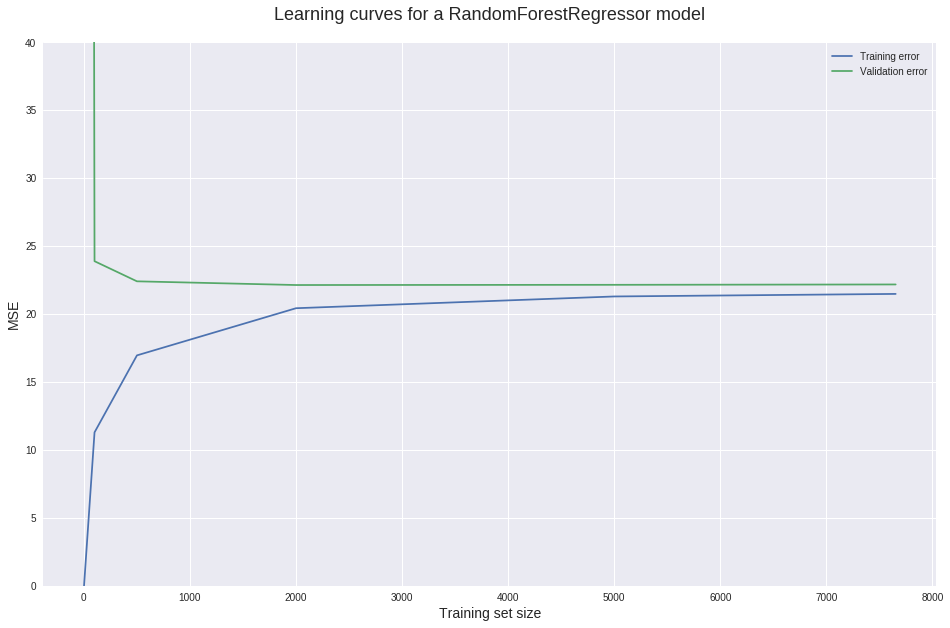

In [28]:
plt.figure(figsize = (16,10))
learning_curves(RandomForestRegressor(max_leaf_nodes = 10, n_estimators=10), df_data, features, target, train_sizes, cv = 5)

The gap is now more narrow, so there is less variance. 

The bias seems to have increased just a bit, which is what we wanted. But our work is far from over! The validation MSE still shows a lot of potential to decrease.

## Exercise

Try to apply the following steps toward the goal of lowering validation error:

1. Adding more training instances.
2. Adding more features.
3. Feature selection.
4. Hyperparameter optimization.

### The ideal learning curves and the irreducible error

Learning curves constitute a great tool to do a quick check on our models at every point in our machine learning workflow. In other words, they are diagnostic instruments, allowing us to monitoring quality of our learning process. But how do we know when to stop? How do we recognize the perfect learning curves? For our regression case before, you might think that the perfect scenario is when both curves converge toward an error of 0. 

That would be a perfect scenario, indeed, but, unfortunately, as you can imagine, it is not possible.

Neither in practice, neither in theory. And this is because of something called _irreducible error_. When we build a model to map the relationship between the features $X$ and the target $Y$ , we assume that there is such a relationship in the first place.

Provided the assumption is true, there is a true model $f$ that describes perfectly the relationship between $X$ and $Y$, like so:

$$ Y = f(X) + \varepsilon_{\mathrm{irr}}\, , $$

where, we denoted with $\varepsilon_{\mathrm{irr}}$ the irreducible error. There is an error there because $Y$ is not only a function of our limited number of features $X$, but it might depend on many other features that influence its value. Features we may not have access to, or simply we do not know.
It might also be the case that $X$ contains measurement errors.

Why do we call it an _irreducible_ error? Well, when we approximate $f$ with another model $\hat{f}$, we introduce another error $\varepsilon$, such that,

$$ Y = \hat{f}(X) + \varepsilon + \varepsilon_{\mathrm{irr}}\, , $$

Errors (like $\varepsilon$) that are reducible can be reduced by building better models. A crucial thing to say is that all the errors are always non-negative, meaning we cannot adjust $\varepsilon$ to cancel $\varepsilon_{\mathrm{irr}}$. Hence the best we can do is $\varepsilon = 0$ while $\varepsilon_{\mathrm{irr}}$ is still there. From here, we deduce that 

> No matter how good our model estimate is, generally there still is some error we cannot reduce.

![title](https://www.dataquest.io/wp-content/uploads/2019/01/irr_error.png)

In practice (and here problems come), the exact value of the irreducible error is almost always unknown. We also assume that the irreducible error is independent of $X$. This means that we cannot use $X$ to find the true irreducible error. Expressing the same thing in the more precise language of mathematics, there is no function $\varphi$ to map $X$ to the true value of the irreducible error:

$$\varepsilon_{\mathrm{irr}} \neq \varphi(X) \, . $$

So there is no way to know the true value of the irreducible error based on the data we have. 

My advice is the following. A good workaround is to try to lower the error score as much as possible, while keeping in mind that the limit is given by some irreducible error.

### Exercise

Try to implement one of the techniques described above to reduce the bias of the regression model we used.

## Exercise

Generate learning curves for a classification task, for example using iris or breast_cancer dataset.

Plot curves and determine whether your classifier is bias or variance affected.